Lab 6 Nebraska

In [1]:
import boto3
from botocore.exceptions import ClientError
import json

def get_secret(secret_name):
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)

In [2]:
import psycopg2

conn = psycopg2.connect(host=get_secret('postgresql')['host'],
                      user=get_secret('postgresql')['username'],
                      password = get_secret('postgresql')['password'],
                      dbname=get_secret('postgresql')['engine'])

cur = conn.cursor()

## Q1- Population Growth Rate

Option 1

In [3]:
ql_sql = """
SELECT 
    p.year,
    p.pop AS population,
    ROUND(
        ( (p.pop::numeric - LAG(p.pop) OVER (ORDER BY p.year)) 
          / LAG(p.pop) OVER (ORDER BY p.year) ) * 100, 
        2
    ) AS growth_rate_percent
FROM 
    population p
JOIN 
    name n 
    ON p.fips = n.fips
WHERE 
    n.name = 'Nebraska'
ORDER BY 
    p.year;
"""

In [4]:
import pandas as pd
ql_df = pd.read_sql(ql_sql, con=conn)
ql_df.head()

/tmp/ipykernel_23758/2819096148.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ql_df = pd.read_sql(ql_sql, con=conn)


,year,population,growth_rate_percent
0,2005,1706976,NaN
1,2006,1768331,3.59
2,2007,1774571,0.35
3,2008,1783432,0.50
4,2009,1796622,0.74


/tmp/ipykernel_23758/237819778.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


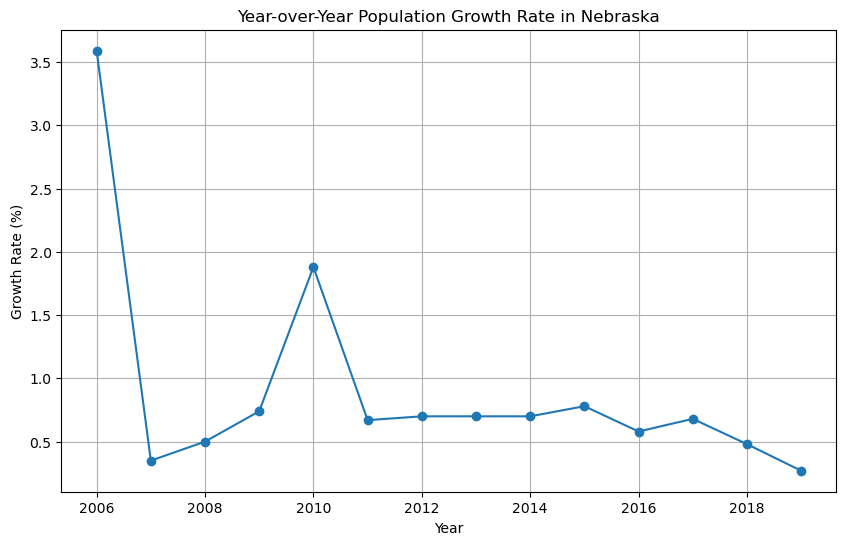

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# --- Run query ---
query = """
SELECT 
    p.year,
    p.pop AS population
FROM 
    population p
JOIN 
    name n 
    ON p.fips = n.fips
WHERE 
    n.name = 'Nebraska'
ORDER BY 
    p.year;
"""
df = pd.read_sql_query(query, conn)
conn.close()

# --- Compute growth rate in Python ---
df['growth_rate_percent'] = df['population'].pct_change() * 100
df['growth_rate_percent'] = df['growth_rate_percent'].round(2)

# --- Plot growth rate ---
plt.figure(figsize=(10, 6))
plt.plot(df['year'], df['growth_rate_percent'], marker='o')
plt.title('Year-over-Year Population Growth Rate in Nebraska')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True)
plt.show()


This question asks for a chart and the calculations of the Year-over-Year population growth of Nebraska which was calculated using code written by JupiterAI.

In [5]:
pip install -U pip setuptools wheel

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --only-binary=:all: "tiktoken>=0.7.0"

Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install "jupyter-ai-magics[all]" -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
%load_ext jupyter_ai_magics

In [9]:
import os
os.environ["OPENAI_API_KEY"] = get_secret('openai')['api_key']

## Q2 - Income and Population Relationship

In [3]:
sql_q2 = """
SELECT 
    p.year,
    p.pop AS population_num,
    i.income AS median_household_income
FROM 
    population p
JOIN 
    income i 
    ON p.fips = i.fips 
    AND p.year = i.year

WHERE 
    p.fips = '31'
"""

In [4]:

# --- Load result into pandas ---
import pandas as pd
q2_df = pd.read_sql(sql_q2, conn)
q2_df.head()

/tmp/ipykernel_28799/1276311428.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  q2_df = pd.read_sql(sql_q2, conn)


,year,population_num,median_household_income
0,2005,1706976,43849
1,2006,1768331,45474
2,2007,1774571,47085
3,2008,1783432,49693
4,2009,1796622,47357


In [12]:
%%ai gpt4 -f code
use the data in the dataframe {q2_df}, the dataframe name is q2_df
Visualization: create a dual-axis chart in Python with Jupyter AI’s help:
o X-axis = year
o Left Y-axis = population (line)
o Right Y-axis = median household income (bar or line, different color)
• Chart must include the state name Nebraska in the title.


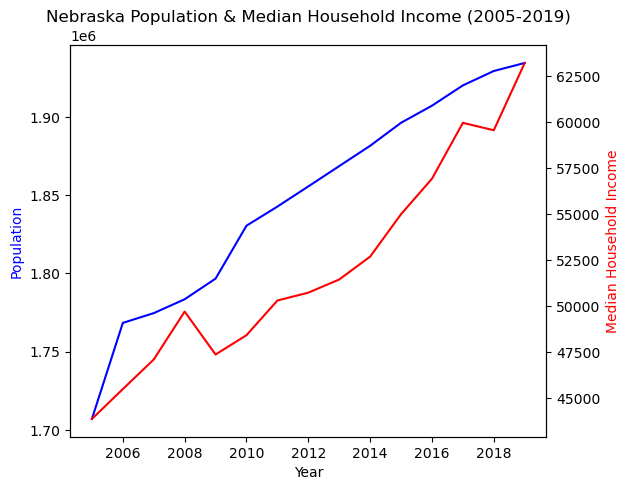

In [13]:
import matplotlib.pyplot as plt

# Extract the data from the dataframe
year = q2_df['year']
population = q2_df['population_num']
median_income = q2_df['median_household_income']

fig, ax1 = plt.subplots()

# Plot the Population on left y-axis
ax1.plot(year, population, color='blue', label='Population')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population', color='blue')

ax2 = ax1.twinx()
# Plot the Median Household Income on right y-axis
ax2.plot(year, median_income, color='red', label='Median Household Income')
ax2.set_ylabel('Median Household Income', color='red')

fig.tight_layout()
plt.title('Nebraska Population & Median Household Income (2005-2019)')
plt.show()

In this question a line graph is made to represent the population of Nebraska on one line and the median household income in a seperate line. These values are determined using code written by the JupiterAI.

## Q3 – Student-Defined Question

In [16]:
%%ai gpt4 -f code
use the data in the dataframe {q2_df}, the dataframe name is q2_df
Which year had the largest population increase? use 
• Write an SQL query to retrieve the needed data. You may need AI assistance to
write the join query correctly

In [17]:
import sqlite3

# Put the q2_df into sqlite3 database in-memory
conn = sqlite3.connect(":memory:")
q2_df.to_sql('q2_df', conn, index=False)

query = """
SELECT year, population_num - LAG(population_num, 1) OVER (ORDER BY year) as population_increase 
FROM q2_df 
ORDER BY population_increase DESC 
LIMIT 1
"""
pd.read_sql_query(query, conn)

,year,population_increase
0,2006,61355


In [20]:
%%ai gpt4 -f code
create a visualization for the year with the largest population increase including the state name of Nebraska in the title

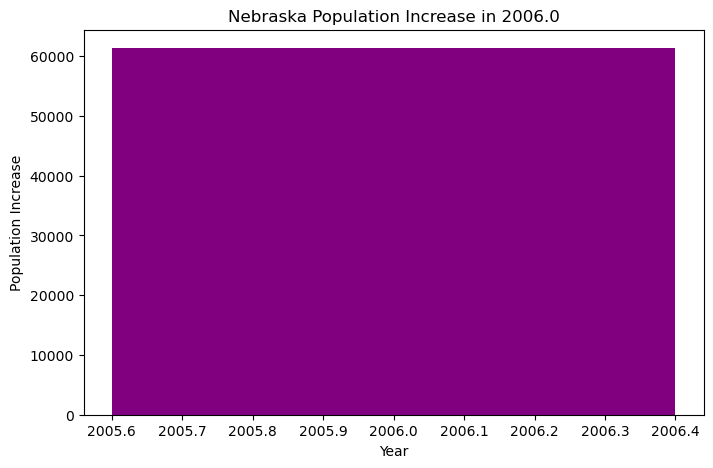

In [21]:
# calculating the difference between consecutive years
q2_df['population_increase'] = q2_df['population_num'].diff()

# getting the year with largest population increase
year_max_increase = q2_df.loc[q2_df['population_increase'].idxmax()]['year']

# creating subset for the year with max increase
subset = q2_df[q2_df['year'] == year_max_increase]

plt.figure(figsize=(8,5))
plt.bar(subset['year'], subset['population_increase'], color='purple')
plt.xlabel("Year")
plt.ylabel("Population Increase")
plt.title("Nebraska Population Increase in " + str(year_max_increase))
plt.show()

A bar chart is made for the year with the largest population increase in Nebraska which was 2006.